In [32]:
import os
import shutil
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from tqdm import tqdm
import json

In [33]:
DATASET_PATH = "dataset"  # Folder dataset asli
OUTPUT_PATH = "processed_dataset"  # Folder output setelah split
LOW_RES_FOLDER = "low_res"
HIGH_RES_FOLDER = "high_res"

In [34]:
SCALE_FACTOR = 4
TARGET_SIZE = (256, 256)  # Target size untuk high-res
LOW_RES_SIZE = (64, 64)   # Target size untuk low-res (256/4)

In [ ]:
def create_folder_structure():
    # Membuat struktur folder untuk dataset yang sudah di-split
    folders = [
        f"{OUTPUT_PATH}/train/{HIGH_RES_FOLDER}",
        f"{OUTPUT_PATH}/train/{LOW_RES_FOLDER}",
        f"{OUTPUT_PATH}/test/{HIGH_RES_FOLDER}",
        f"{OUTPUT_PATH}/test/{LOW_RES_FOLDER}"
    ]
    
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        print(f"Created folder: {folder}")

create_folder_structure()

Created folder: processed_dataset/train/high_res
Created folder: processed_dataset/train/low_res
Created folder: processed_dataset/test/high_res
Created folder: processed_dataset/test/low_res


In [ ]:
def get_image_pairs(dataset_path):
    # Mendapatkan pasangan gambar high-res dan low-res"
    low_res_pattern = os.path.join(dataset_path, "*_4.jpg")
    low_res_files = glob.glob(low_res_pattern)
    
    image_pairs = []
    
    for low_res_file in low_res_files:
        # Dapatkan nama file high-res dengan menghilangkan _4
        base_name = os.path.basename(low_res_file).replace("_4.jpg", ".jpg")
        high_res_file = os.path.join(dataset_path, base_name)
        
        # Cek apakah file high-res ada
        if os.path.exists(high_res_file):
            image_pairs.append((high_res_file, low_res_file))
        else:
            print(f"Warning: High-res file not found for {low_res_file}")
    
    return image_pairs

# Dapatkan pasangan gambar
image_pairs = get_image_pairs(DATASET_PATH)
print(f"Found {len(image_pairs)} image pairs")

Found 0 image pairs


In [ ]:
def preprocess_image(image_path, target_size, is_high_res=True):
    # Preprocessing gambar untuk training
    try:
        # Baca gambar
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Cannot read image: {image_path}")
        
        # Konversi BGR ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize gambar
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        
        # Normalisasi ke range [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [38]:
def save_preprocessed_image(img_array, output_path):
    """Simpan gambar yang sudah dipreprocess"""
    try:
        # Denormalisasi ke range [0, 255]
        img_array = (img_array * 255).astype(np.uint8)
        
        # Konversi ke PIL Image dan simpan
        img_pil = Image.fromarray(img_array)
        img_pil.save(output_path, "JPEG", quality=95)
        
        return True
    except Exception as e:
        print(f"Error saving image to {output_path}: {e}")
        return False

In [ ]:
import os

low_dir = "dataset/low_res"
high_dir = "dataset/high_res"

low_list = sorted([f for f in os.listdir(low_dir) if f.endswith('.jpg')])
high_list = sorted([f for f in os.listdir(high_dir) if f.endswith('.jpg')])

image_pairs = []

for low_img in low_list:
    high_img = low_img.replace('_4', '')  
    if high_img in high_list:
        low_path = os.path.join(low_dir, low_img)
        high_path = os.path.join(high_dir, high_img)
        image_pairs.append((low_path, high_path))

print("Jumlah total pasangan gambar:", len(image_pairs))
print("Contoh isi image_pairs:", image_pairs[:5])

if len(image_pairs) == 0:
    raise ValueError("❗ image_pairs kosong! Pastikan nama file low-res dan high-res cocok.")

from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(image_pairs, test_size=0.2, random_state=42)

print(f"✅ Training pairs: {len(train_pairs)}")
print(f"✅ Testing pairs: {len(test_pairs)}")


Jumlah total pasangan gambar: 1254
Contoh isi image_pairs: [('dataset/low_res\\1000_4.jpg', 'dataset/high_res\\1000.jpg'), ('dataset/low_res\\1001_4.jpg', 'dataset/high_res\\1001.jpg'), ('dataset/low_res\\1002_4.jpg', 'dataset/high_res\\1002.jpg'), ('dataset/low_res\\1003_4.jpg', 'dataset/high_res\\1003.jpg'), ('dataset/low_res\\1004_4.jpg', 'dataset/high_res\\1004.jpg')]
✅ Training pairs: 1003
✅ Testing pairs: 251


In [ ]:
def process_and_save_dataset(pairs, split_name):
    # Process dan simpan dataset untuk split tertentu
    successful_count = 0
    
    for i, (high_res_path, low_res_path) in enumerate(tqdm(pairs, desc=f"Processing {split_name}")):
        try:
            # Preprocess high-res image
            high_res_img = preprocess_image(high_res_path, TARGET_SIZE, True)
            if high_res_img is None:
                continue
                
            # Preprocess low-res image
            low_res_img = preprocess_image(low_res_path, LOW_RES_SIZE, False)
            if low_res_img is None:
                continue
            
            # Generate nama file output
            base_name = f"{i+1:04d}.jpg"
            
            # Path output
            high_res_output = os.path.join(OUTPUT_PATH, split_name, HIGH_RES_FOLDER, base_name)
            low_res_output = os.path.join(OUTPUT_PATH, split_name, LOW_RES_FOLDER, base_name)
            
            # Simpan gambar
            if (save_preprocessed_image(high_res_img, high_res_output) and 
                save_preprocessed_image(low_res_img, low_res_output)):
                successful_count += 1
                
        except Exception as e:
            print(f"Error processing pair {i}: {e}")
    
    print(f"{split_name}: Successfully processed {successful_count}/{len(pairs)} pairs")
    return successful_count


In [ ]:
train_success = process_and_save_dataset(train_pairs, "train")

# Process testing data
test_success = process_and_save_dataset(test_pairs, "test")

# Simpan informasi dataset
dataset_info = {
    "scale_factor": SCALE_FACTOR,
    "target_size": TARGET_SIZE,
    "low_res_size": LOW_RES_SIZE,
    "total_pairs": len(image_pairs),
    "train_pairs": train_success,
    "test_pairs": test_success,
    "split_ratio": "80:20"
}

with open(os.path.join(OUTPUT_PATH, "dataset_info.json"), "w") as f:
    json.dump(dataset_info, f, indent=2)

print("Dataset info saved!")

Processing train: 100%|██████████| 1003/1003 [01:51<00:00,  8.99it/s]


train: Successfully processed 1003/1003 pairs


Processing test: 100%|██████████| 251/251 [00:22<00:00, 11.18it/s]

test: Successfully processed 251/251 pairs
Dataset info saved!


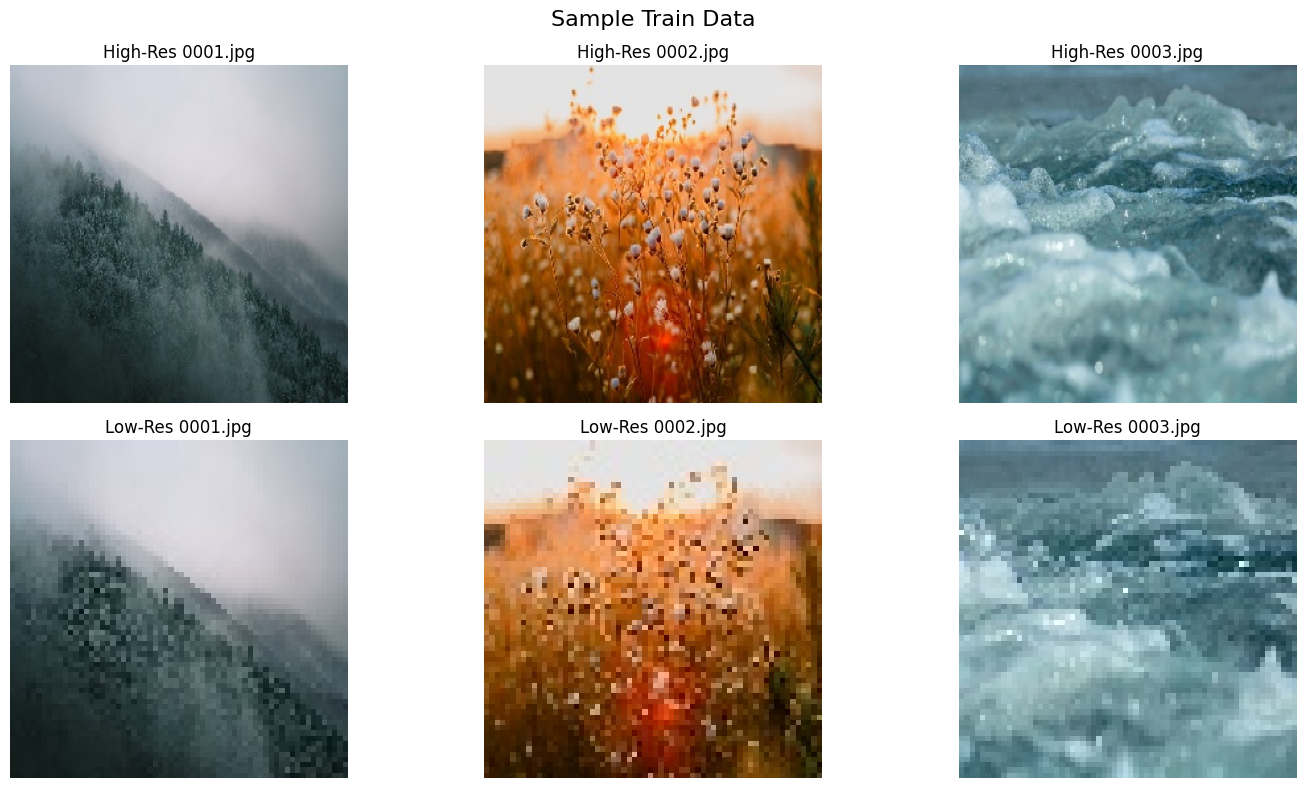

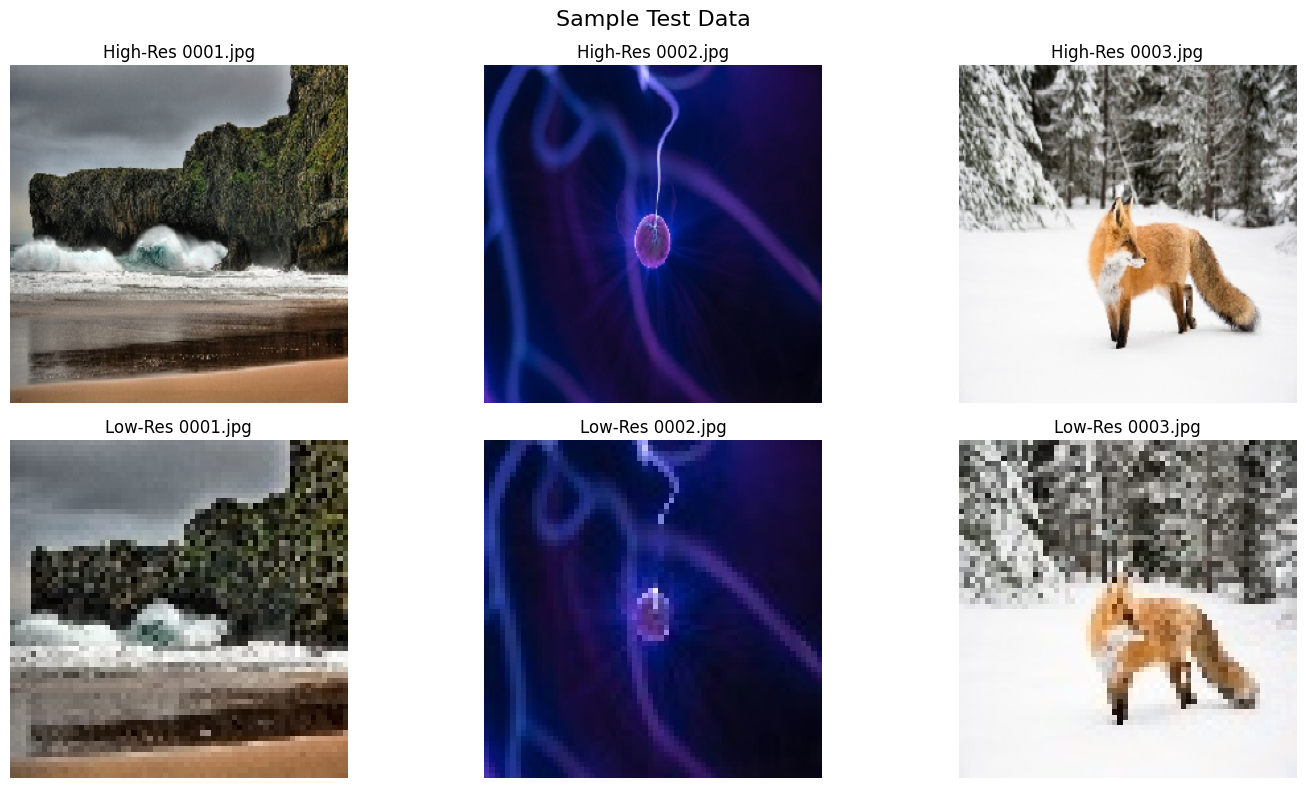

In [ ]:
def visualize_samples(split_name, num_samples=3):
    # Visualisasi beberapa sample dari dataset
    high_res_path = os.path.join(OUTPUT_PATH, split_name, HIGH_RES_FOLDER)
    low_res_path = os.path.join(OUTPUT_PATH, split_name, LOW_RES_FOLDER)
    
    # Ambil beberapa file sample
    sample_files = sorted(os.listdir(high_res_path))[:num_samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    fig.suptitle(f"Sample {split_name.title()} Data", fontsize=16)
    
    for i, filename in enumerate(sample_files):
        # Load images
        high_res_img = cv2.imread(os.path.join(high_res_path, filename))
        low_res_img = cv2.imread(os.path.join(low_res_path, filename))
        
        # Convert BGR to RGB
        high_res_img = cv2.cvtColor(high_res_img, cv2.COLOR_BGR2RGB)
        low_res_img = cv2.cvtColor(low_res_img, cv2.COLOR_BGR2RGB)
        
        # Plot
        axes[0, i].imshow(high_res_img)
        axes[0, i].set_title(f"High-Res {filename}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(low_res_img)
        axes[1, i].set_title(f"Low-Res {filename}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisasi sample training data
visualize_samples("train", 3)

# In[11]:

# Visualisasi sample testing data
visualize_samples("test", 3)

In [ ]:
def print_dataset_summary():
    # Print ringkasan dataset
    print("="*50)
    print("DATASET SUMMARY")
    print("="*50)
    
    # Load dataset info
    with open(os.path.join(OUTPUT_PATH, "dataset_info.json"), "r") as f:
        info = json.load(f)
    
    print(f"Scale Factor: {info['scale_factor']}x")
    print(f"High-Res Size: {info['target_size']}")
    print(f"Low-Res Size: {info['low_res_size']}")
    print(f"Total Original Pairs: {info['total_pairs']}")
    print(f"Training Pairs: {info['train_pairs']}")
    print(f"Testing Pairs: {info['test_pairs']}")
    print(f"Split Ratio: {info['split_ratio']}")
    
    # Folder structure
    print("\nFolder Structure:")
    for root, dirs, files in os.walk(OUTPUT_PATH):
        level = root.replace(OUTPUT_PATH, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... and {len(files)-3} more files")
    
    print("\n✅ Dataset preprocessing completed successfully!")

print_dataset_summary()


DATASET SUMMARY
Scale Factor: 4x
High-Res Size: [256, 256]
Low-Res Size: [64, 64]
Total Original Pairs: 1254
Training Pairs: 1003
Testing Pairs: 251
Split Ratio: 80:20

Folder Structure:
processed_dataset/
  dataset_info.json
  train/
    high_res/
      0001.jpg
      0002.jpg
      0003.jpg
      ... and 1000 more files
    low_res/
      0001.jpg
      0002.jpg
      0003.jpg
      ... and 1000 more files
  test/
    high_res/
      0001.jpg
      0002.jpg
      0003.jpg
      ... and 248 more files
    low_res/
      0001.jpg
      0002.jpg
      0003.jpg
      ... and 248 more files

✅ Dataset preprocessing completed successfully!


In [ ]:
def validate_dataset():
    # Validasi dataset yang sudah diprocess
    issues = []
    
    for split in ["train", "test"]:
        high_res_path = os.path.join(OUTPUT_PATH, split, HIGH_RES_FOLDER)
        low_res_path = os.path.join(OUTPUT_PATH, split, LOW_RES_FOLDER)
        
        high_res_files = set(os.listdir(high_res_path))
        low_res_files = set(os.listdir(low_res_path))
        
        # Cek apakah jumlah file sama
        if len(high_res_files) != len(low_res_files):
            issues.append(f"{split}: Mismatch in number of files")
        
        # Cek apakah nama file sama
        if high_res_files != low_res_files:
            issues.append(f"{split}: Mismatch in file names")
        
        # Cek ukuran gambar
        for filename in list(high_res_files)[:5]:  # Check first 5 files
            hr_img = cv2.imread(os.path.join(high_res_path, filename))
            lr_img = cv2.imread(os.path.join(low_res_path, filename))
            
            if hr_img.shape[:2] != TARGET_SIZE:
                issues.append(f"{split}/{filename}: Wrong high-res size")
            
            if lr_img.shape[:2] != LOW_RES_SIZE:
                issues.append(f"{split}/{filename}: Wrong low-res size")
    
    if issues:
        print("⚠️  Issues found:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("✅ Dataset validation passed!")

validate_dataset()

✅ Dataset validation passed!
